<a href="https://colab.research.google.com/github/diaboloshogunate/GoogleColabML/blob/main/MNIST-encode-decode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

data_dir = 'dataset'

train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

train_transform = transforms.Compose([transforms.ToTensor(),])

test_transform = transforms.Compose([transforms.ToTensor(),])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

Selected device: cuda


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [2]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class Decoder(nn.Module):
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [3]:
def add_noise(inputs,noise_factor=0.3):
     noisy = inputs+torch.randn_like(inputs) * noise_factor
     noisy = torch.clip(noisy,0.,1.)
     return noisy

In [4]:
def train_epoch_den(encoder, decoder, device, dataloader, loss_fn, optimizer,noise_factor=0.3):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, _ in dataloader:
        image_noisy = add_noise(image_batch,noise_factor)
        image_batch = image_batch.to(device)
        image_noisy = image_noisy.to(device)
        encoded_data = encoder(image_noisy)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [5]:
def plot_ae_outputs_den(encoder,decoder,n=10,noise_factor=0.3):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}    
    for i in range(n):

      ax = plt.subplot(3,n,i+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0)
      image_noisy = add_noise(img,noise_factor)     
      image_noisy = image_noisy.to(device)

      encoder.eval()
      decoder.eval()

      with torch.no_grad():
         rec_img  = decoder(encoder(image_noisy))

      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(image_noisy.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Corrupted images')

      ax = plt.subplot(3, n, i + 1 + n + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()

Noise: 0.1
EPOCH 1/20
EPOCH 2/20
EPOCH 3/20
EPOCH 4/20
EPOCH 5/20
EPOCH 6/20
EPOCH 7/20
EPOCH 8/20
EPOCH 9/20
EPOCH 10/20
EPOCH 11/20
EPOCH 12/20
EPOCH 13/20
EPOCH 14/20
EPOCH 15/20
EPOCH 16/20
EPOCH 17/20
EPOCH 18/20
EPOCH 19/20
EPOCH 20/20


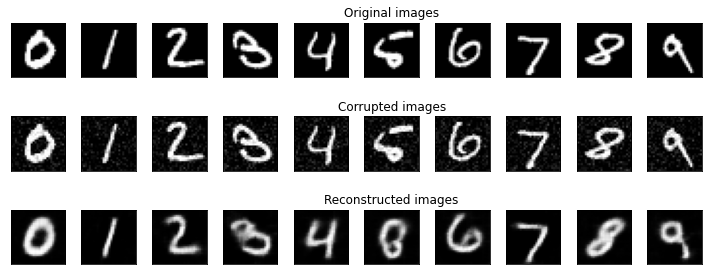

Noise: 0.2
EPOCH 1/20
EPOCH 2/20
EPOCH 3/20
EPOCH 4/20
EPOCH 5/20
EPOCH 6/20
EPOCH 7/20
EPOCH 8/20
EPOCH 9/20
EPOCH 10/20
EPOCH 11/20
EPOCH 12/20
EPOCH 13/20
EPOCH 14/20
EPOCH 15/20
EPOCH 16/20
EPOCH 17/20
EPOCH 18/20
EPOCH 19/20
EPOCH 20/20


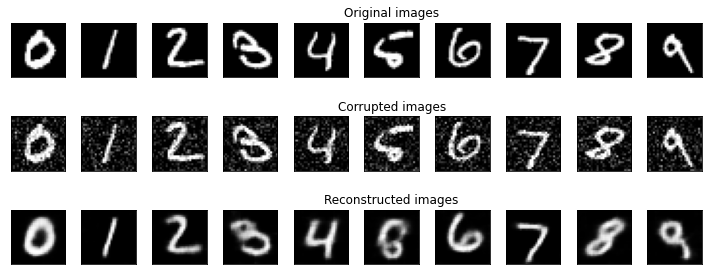

Noise: 0.3
EPOCH 1/20
EPOCH 2/20
EPOCH 3/20
EPOCH 4/20
EPOCH 5/20
EPOCH 6/20
EPOCH 7/20
EPOCH 8/20
EPOCH 9/20
EPOCH 10/20
EPOCH 11/20
EPOCH 12/20
EPOCH 13/20
EPOCH 14/20
EPOCH 15/20
EPOCH 16/20
EPOCH 17/20
EPOCH 18/20
EPOCH 19/20
EPOCH 20/20


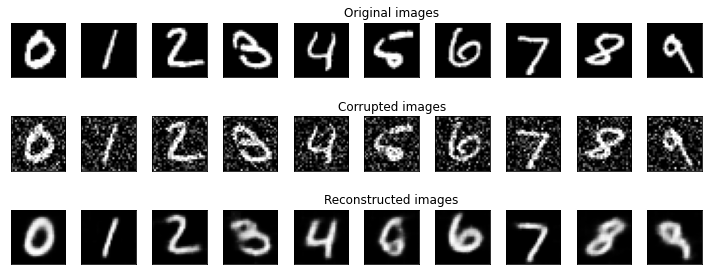

Noise: 0.4
EPOCH 1/20
EPOCH 2/20
EPOCH 3/20
EPOCH 4/20
EPOCH 5/20
EPOCH 6/20
EPOCH 7/20
EPOCH 8/20
EPOCH 9/20
EPOCH 10/20
EPOCH 11/20
EPOCH 12/20
EPOCH 13/20
EPOCH 14/20
EPOCH 15/20
EPOCH 16/20
EPOCH 17/20
EPOCH 18/20
EPOCH 19/20
EPOCH 20/20


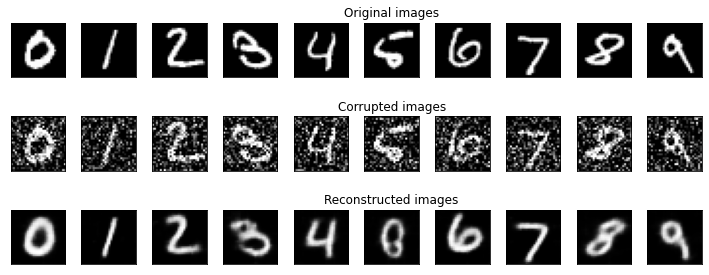

Noise: 0.5
EPOCH 1/20
EPOCH 2/20
EPOCH 3/20
EPOCH 4/20
EPOCH 5/20
EPOCH 6/20
EPOCH 7/20
EPOCH 8/20
EPOCH 9/20
EPOCH 10/20
EPOCH 11/20
EPOCH 12/20
EPOCH 13/20
EPOCH 14/20
EPOCH 15/20
EPOCH 16/20
EPOCH 17/20
EPOCH 18/20
EPOCH 19/20
EPOCH 20/20


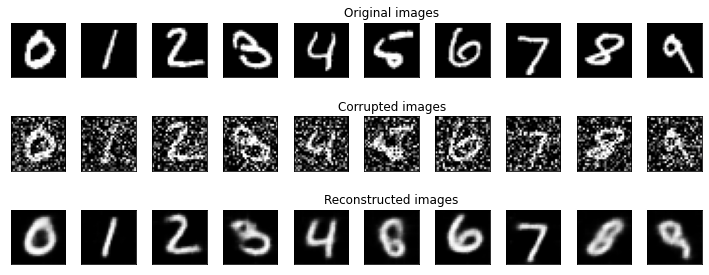

Noise: 0.6
EPOCH 1/20
EPOCH 2/20
EPOCH 3/20
EPOCH 4/20
EPOCH 5/20
EPOCH 6/20
EPOCH 7/20
EPOCH 8/20
EPOCH 9/20
EPOCH 10/20
EPOCH 11/20
EPOCH 12/20
EPOCH 13/20
EPOCH 14/20
EPOCH 15/20
EPOCH 16/20
EPOCH 17/20
EPOCH 18/20
EPOCH 19/20
EPOCH 20/20


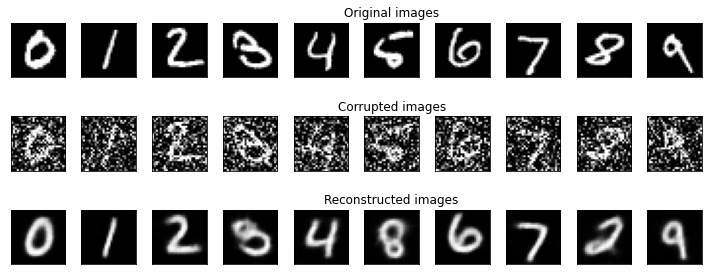

Noise: 0.7
EPOCH 1/20
EPOCH 2/20
EPOCH 3/20
EPOCH 4/20
EPOCH 5/20
EPOCH 6/20
EPOCH 7/20
EPOCH 8/20
EPOCH 9/20
EPOCH 10/20
EPOCH 11/20
EPOCH 12/20
EPOCH 13/20
EPOCH 14/20
EPOCH 15/20
EPOCH 16/20
EPOCH 17/20
EPOCH 18/20
EPOCH 19/20
EPOCH 20/20


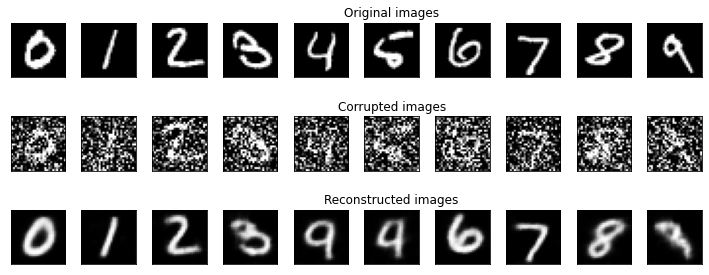

Noise: 0.8
EPOCH 1/20
EPOCH 2/20
EPOCH 3/20
EPOCH 4/20
EPOCH 5/20
EPOCH 6/20
EPOCH 7/20
EPOCH 8/20
EPOCH 9/20
EPOCH 10/20
EPOCH 11/20
EPOCH 12/20
EPOCH 13/20
EPOCH 14/20
EPOCH 15/20
EPOCH 16/20
EPOCH 17/20
EPOCH 18/20
EPOCH 19/20
EPOCH 20/20


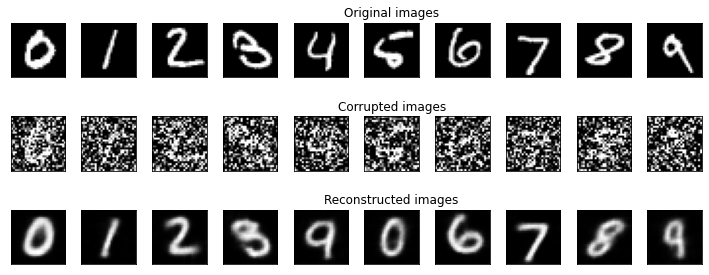

In [6]:
num_epochs = 20
loss_fn = torch.nn.MSELoss()
lr= 0.001
torch.manual_seed(0)
d = 4

encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [{'params': encoder.parameters()}, {'params': decoder.parameters()}]
optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

encoder.to(device)
decoder.to(device)
for x in range(1,9):
  noise_factor = x/10;
  print(f'Noise: {noise_factor}')
  for epoch in range(num_epochs):
      print('EPOCH %d/%d' % (epoch + 1, num_epochs))
      train_loss=train_epoch_den(encoder=encoder, decoder=decoder, device=device, dataloader=train_loader, loss_fn=loss_fn, optimizer=optim,noise_factor=noise_factor)

  plot_ae_outputs_den(encoder,decoder,noise_factor=noise_factor)